In [1]:
from scipy.special import comb
import math

# n_classifier：　クラスの数
# error：　個々の分類器の誤分類率（全ての分類器が同じ誤分類である、という前提）
def ensamble_error(n_classifier, error):
    # kは、誤分類する分類器の数
    k_start = int(math.ceil(n_classifier / 2.))
    
    # combは、いわゆる i C j 。つまり組み合わせを算出する。
    #  n_classifier個の分類器のうちk個が誤分類する確率を算出する。
    # kがn_classifier個の半分からn_classifier個の場合までを算出し、それぞれの結果をリストに格納している。
    probs = [comb(n_classifier, k) * (error ** k) *  ( (1-error)**(n_classifier - k) )
                     for k in range(k_start, n_classifier + 1)]
    
    return sum(probs)

ensamble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [2]:
import math

math.ceil(3.2)

4

In [3]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)

ens_errors = [ensamble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensamble classifier', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base classifier', linewidth=2)

plt.xlabel('error rate of each base classifier')
plt.ylabel('error rate')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

# 個々のベース分類器の誤分類率が0.5より小さい（当てずっぽうより良い）場合、アンサンブル分類器の方が誤分類率が低い（優秀）。

<Figure size 640x480 with 1 Axes>

In [4]:
a = np.bincount([0, 0, 1])
b = np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])

print(a) # 0が２回、1が1回なので、結果は[2 1]
print(np.argmax(a)) # インデックス0の要素が最大なので、結果は0

print(b)# 0が２回、1が1回なので、結果は[0.2 × 2回  0.6 × 1回] = [0.4 0.6]
print(np.argmax(b))# インデックス1の要素が最大なので、結果は1

[2 1]
0
[0.4 0.6]
1


In [5]:
ex = np.array([[0.9, 0.1],
                          [0.8, 0.2],
                          [0.4, 0.6]])

# 1行目に0.2、２行目に0.2、3行目に0.6を掛けた後、列ごとに平均を算出。
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6]) 
print(p)

np.argmax(p)

[0.58 0.42]


0

In [69]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassfier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        
        '''
        _name_estimators()が返却するものの例：　
        key：'pipeline'
        value: 'Pipeline(memory=None, 
                                  steps=[['sc',StandardScaler(copy=True, with_mean=True,with_std=True)],
                                               ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=1, solver='warn', tol=0.0001, verbose=0, warm_start=False)]],
                                  verbose=False)' 
        '''
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        
        '''
        for key, value in _name_estimators(classifiers):
           print("[%s] :  [%s]" % (key, value))
        print(len(self.named_classifiers))
        '''        
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        
        return self
    
    def predict(self, X):

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            '''
            for clf in self.classifiers_:
                a = clf.predict(X)
                print('★[clf.predict(X)]')
                print(a)
                # [array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1])]
                
                print('★np.asarray([clf.predict(X)]).T')
                print(np.asarray([a]).T)
                # [[0]
                #  [0]
                #  ・・・
                #  [0]
                #  [1]]
            '''
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            '''
            1行は入力データ１件に対応
            1列は分類器１つに対応
            [[0 0]
             ・・・
             [1 1]]
            '''
            
            # ここでのaxis = 1は列単位を表す。2列まるごと、というイメージがわかりやすい。入力データ１件ごとに多数決をとっている。
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                                                      axis=1, arr=predictions)
            # [0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1]
        
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        '''
        for clf in self.classifiers_:
            a = clf.predict_proba(X)
            print([a])
            #[array([[0.50345432, 0.49654568],
            #       ・・・
            #       [0.49936203, 0.50063797]])]
            
            print(np.asarray([a]))
            # [[[0.50345432 0.49654568]
            #  ・・・
            #  [0.49936203 0.50063797]]]
        '''
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        
        '''
        self.classifiers_ が２つの場合
        print(probas)
        # [[[0.50345432 0.49654568]
        #   ・・・
        #   [0.49936203 0.50063797]]
        # 
        #  [[0.92307692 0.07692308]
        #   ・・・
        #   [0.         1.        ]]]
        '''

        # 同一の入力データに対する2つの分類器の結果を、平均している。
        # axis = 0　なので、1つ目の分類器の結果と、2つ目の分類器の結果が丸ごと平均されている。
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        # print(avg_proba)
        # [[0.71326562 0.28673438]
        # 　・・・
        #  [0.24968101 0.75031899]]        
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassfier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            
            for name, step in six.iteritems(self.named_classifiers):
                # print('★name: ', name)
                # print('★step: ', step)
                '''
               ★name:  pipeline
               ★step:  Pipeline(memory=None,
                         steps=[['sc',
                                 StandardScaler(copy=True, with_mean=True, with_std=True)],
                                ['clf',
                                 LogisticRegression(C=0.001, class_weight=None, dual=False,
                                                    fit_intercept=True, intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='warn', n_jobs=None,
                                                    penalty='l2', random_state=1, solver='warn',
                                                    tol=0.0001, verbose=0, warm_start=False)]],
                         verbose=False)
                '''
                
                for key, value in six.iteritems(step.get_params(deep=True)):
                    
                    # print('★key: ', key)
                    # print('★value: ', value)
                    '''
                    ★key:  memory
                    ★value:  None
                    ★key:  steps
                    ★value:  [['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None, max_iter=100,
                                       multi_class='warn', n_jobs=None, penalty='l2',
                                       random_state=1, solver='warn', tol=0.0001, verbose=0,
                                       warm_start=False)]]
                    ★key:  verbose
                    ★value:  False
                    ★key:  sc
                    ★value:  StandardScaler(copy=True, with_mean=True, with_std=True)
                    ★key:  clf
                    ★value:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None, max_iter=100,
                                       multi_class='warn', n_jobs=None, penalty='l2',
                                       random_state=1, solver='warn', tol=0.0001, verbose=0,
                                       warm_start=False)
                    ★key:  sc__copy
                    ★value:  True
                    ★key:  sc__with_mean
                    ★value:  True
                    ★key:  sc__with_std
                    ★value:  True
                    ★key:  clf__C
                    ★value:  0.001
                    ★key:  clf__class_weight
                    ★value:  None
                    ★key:  clf__dual
                    ★value:  False
                    ★key:  clf__fit_intercept
                    ★value:  True
                    ★key:  clf__intercept_scaling
                    ★value:  1
                    ★key:  clf__l1_ratio
                    ★value:  None
                    ★key:  clf__max_iter
                    ★value:  100
                    ★key:  clf__multi_class
                    ★value:  warn
                    ★key:  clf__n_jobs
                    ★value:  None
                    ★key:  clf__penalty
                    ★value:  l2
                    ★key:  clf__random_state
                    ★value:  1
                    ★key:  clf__solver
                    ★value:  warn
                    ★key:  clf__tol
                    ★value:  0.0001
                    ★key:  clf__verbose
                    ★value:  0
                    ★key:  clf__warm_start
                    ★value:  False
                    '''
                    
                    out['%s__%s' % (name, key)] = value
            
            return out


In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regrression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [70]:
mv_clf = MajorityVoteClassfier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regrression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majorrity voting]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [57]:
mv_clf = MajorityVoteClassfier(classifiers=[pipe1, clf2])
scores = cross_val_score(estimator=mv_clf, X=X_train, y=y_train, cv=2, scoring='roc_auc')
print("ROC AUC: %0.2f (+/- %0.2f) [Majority voting]" % (scores.mean(), scores.std()))

[[0.71326562 0.28673438]
 [0.25013836 0.74986164]
 [0.24854038 0.75145962]
 [0.24930997 0.75069003]
 [0.71384967 0.28615033]
 [0.24897937 0.75102063]
 [0.24988489 0.75011511]
 [0.71179439 0.28820561]
 [0.25123857 0.74876143]
 [0.24994367 0.75005633]
 [0.71223339 0.28776661]
 [0.71358704 0.28641296]
 [0.71198908 0.28801092]
 [0.71236012 0.28763988]
 [0.24942754 0.75057246]
 [0.71134621 0.28865379]
 [0.71403517 0.28596483]
 [0.71107439 0.28892561]
 [0.24634936 0.75365064]
 [0.24885263 0.75114737]
 [0.2487259  0.7512741 ]
 [0.25013836 0.74986164]
 [0.71186235 0.28813765]
 [0.71230134 0.28769866]
 [0.71319767 0.28680233]
 [0.24968101 0.75031899]]
[[0.28576244 0.71423756]
 [0.74994138 0.25005862]
 [0.28595557 0.71404443]
 [0.28576244 0.71423756]
 [0.75149053 0.24850947]
 [0.28119772 0.71880228]
 [0.28536393 0.71463607]
 [0.28334219 0.71665781]
 [0.28372027 0.71627973]
 [0.75032766 0.24967234]
 [0.28372435 0.71627565]
 [0.28487905 0.71512095]
 [0.7511988  0.2488012 ]
 [0.28527348 0.71472652]

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
mv_clf = MajorityVoteClassfier(classifiers=[pipe1, clf2])
scores = cross_val_score(estimator=mv_clf, X=X_train, y=y_train, cv=2)
print("ROC AUC: %0.2f (+/- %0.2f) [Majority voting]" % (scores.mean(), scores.std()))

ROC AUC: 0.82 (+/- 0.01) [Majority voting]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
mv_clf = MajorityVoteClassfier(classifiers=[pipe1, clf2])
a = mv_clf.get_params()

★key:  memory
★value:  None
★key:  steps
★value:  [['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)]]
★key:  verbose
★value:  False
★key:  sc
★value:  StandardScaler(copy=True, with_mean=True, with_std=True)
★key:  clf
★value:  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
★key:  sc__copy
★value:  True
★key:  sc__with_mean
★value:  True
★key:  sc__with_std
★value:  True


In [71]:
mv_clf = MajorityVoteClassfier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['MajorityVoteClassfier']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

ROC AUC: 0.87 (+/- 0.17) [Logistic regrression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majorrity voting]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


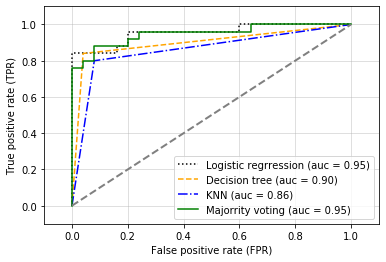

In [73]:
from sklearn.metrics import roc_curve, auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


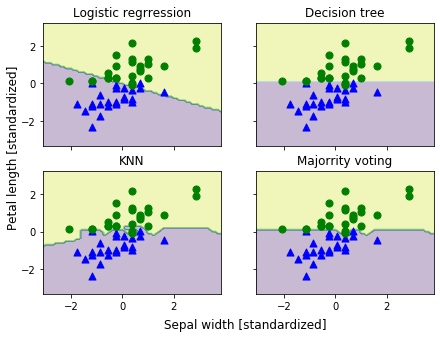

In [94]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
# xx　には、左端から右端までのx軸の刻みが、下端から上端までのy軸の刻みの数だけある。 yyも同様。

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) # http://kaisk.hatenadiary.com/entry/2014/11/05/041011
    # print(Z)
    # print("Z.shape: ", Z.shape)  ->  (4690,)
    Z = Z.reshape(xx.shape)
    # print("Z.reshape: ", Z.shape) ->  (67, 70)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -5., s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)

plt.show()
    

In [95]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='warn', n_jobs=None,
                                     penalty='l2', random_state=1, solver='warn',
                                     tol=0.0001, verbose=0, warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=

In [97]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
                   'pipeline-1__clf__C': [0.001, 0.1, 100.0]  }

grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MajorityVoteClassfier(classifiers=[Pipeline(memory=None,
                                                                   steps=[('sc',
                                                                           StandardScaler(copy=True,
                                                                                          with_mean=True,
                                                                                          with_std=True)),
                                                                          ['clf',
                                                                           LogisticRegression(C=0.001,
                                                                                              class_weight=None,
                                                                                              dual=False,
                                                                    

In [101]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r" % (grid.cv_results_['mean_test_score'][r], grid.cv_results_['std_test_score'][r] /2.0, grid.cv_results_['params'][r]))

print('Best parameters: %s' % grid.best_params_)

print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Colorr intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [5]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [6]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


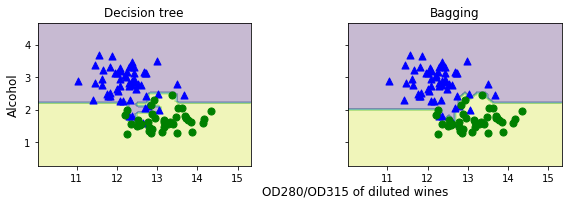

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()
    

In [13]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


In [15]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


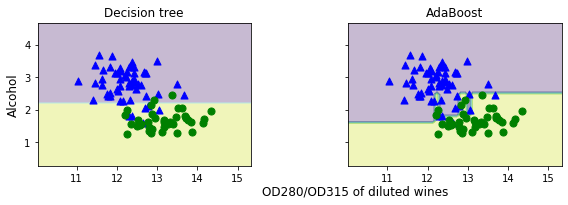

In [16]:
import matplotlib.pyplot as plt
import numpy as np

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()
    